In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
from IPython.display import clear_output

import librosa

import torch 
import torch.nn as nn  

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score

import time

## Preprocessing

In [2]:
class1_dir= '../chunked_files/Experiment-1/PartA/' # path to audio data of class 1
class2_dir= '../chunked_files/Experiment-1/PartB/' # path to audio data of class 2
class1_ds_len = len(os.listdir(class1_dir))
class2_ds_len = len(os.listdir(class2_dir))

In [3]:
def get_durations(audio_dir, duration_threshold):
    audio_files = os.listdir(audio_dir)
    audio_durations = {
        'Name' : [], 
        'Duration' : []
    }

    for audio_file in audio_files:
        duration = librosa.get_duration(path=audio_dir + audio_file)
        if duration >= duration_threshold:
            audio_durations['Name'].append(audio_file)
            audio_durations['Duration'].append(duration)
    
    audio_durations['Duration'] = np.asarray(audio_durations['Duration'])
    
    return audio_durations

In [4]:
def find_optimal_shape(
    audio_class_1, 
    audio_class_2, 
    class_1_dir_name, 
    default_mean_time):
    
    if default_mean_time:
        mean_time = default_mean_time # seconds
    else:
        class_1_mean_duration = audio_class_1['Duration'].mean()
        class_2_mean_duration = audio_class_2['Duration'].mean()
        mean_time = (class_1_mean_duration + class_2_mean_duration) / 2

    class_1_max_duration = audio_class_1['Duration'].max() # makes sure that the audio is > mean duration

    max_audio_file = ''
    for name, duration in zip(audio_class_1['Name'], audio_class_1['Duration']):
        if duration == class_1_max_duration:
            max_audio_file = class_1_dir_name + name
            break
    
    y, _ = librosa.load(max_audio_file, duration=mean_time)

    optimal_shape = y.shape
    return mean_time, optimal_shape

In [5]:
def load_audio_files(audio_dir, optimal_shape, mean_duration, label):
    audio_files = os.listdir(audio_dir)
    class_preprocessed = {
        'Name': [],
        'Audio_samples' : [],
        'Label' : []
    }
    
    for audio_file in audio_files:
        y, sr = librosa.load(audio_dir + audio_file, duration=mean_duration)
        y = librosa.util.fix_length(y, size=optimal_shape[0], mode='mean')
        
        class_preprocessed['Name'].append(audio_file)
        class_preprocessed['Audio_samples'].append(y)
        class_preprocessed['Label'].append(label)

    return class_preprocessed, sr

In [6]:
class_1_ds = get_durations(
    audio_dir=class1_dir, 
    duration_threshold=10)

class_2_ds = get_durations(
    audio_dir=class2_dir, 
    duration_threshold=10)

In [7]:
mean_duration, optimal_shape = find_optimal_shape(
    audio_class_1=class_1_ds, 
    audio_class_2=class_2_ds, 
    class_1_dir_name=class1_dir, 
    default_mean_time=10)

In [8]:
class_1_preprocessed, sampling_rate = load_audio_files(
                                        audio_dir=class1_dir, 
                                        optimal_shape=optimal_shape, 
                                        mean_duration=mean_duration, 
                                        label='MH')

In [9]:
class_2_preprocessed, sampling_rate = load_audio_files(
                                        audio_dir=class2_dir, 
                                        optimal_shape=optimal_shape, 
                                        mean_duration=mean_duration, 
                                        label='MM')

## STE Based Selection of Data

In [10]:
def get_ste_for_audio_signals(
    audio_signals, 
    frame_length=2048, 
    hop_length=1024):
    
    ste_per_audio_signal = []

    for audio_signal in audio_signals:
        frames = librosa.util.frame(
            audio_signal, 
            frame_length=frame_length, 
            hop_length=hop_length, 
            axis=0)
        
        ste = np.square(frames).sum(axis=1).mean(axis=0)
        ste_per_audio_signal.append(ste)
    
    ste_per_audio_signal = np.asarray(ste_per_audio_signal)
    return ste_per_audio_signal

In [11]:
STEs_class1_signals = get_ste_for_audio_signals(
    audio_signals=class_1_preprocessed['Audio_samples'],
    frame_length=2048,
    hop_length=1024)

In [12]:
STEs_class2_signals = get_ste_for_audio_signals(
    audio_signals=class_2_preprocessed['Audio_samples'], 
    frame_length=2048, 
    hop_length=1024)

In [13]:
minmax_scaler = MinMaxScaler()

In [14]:
STEs_class1_signals_normalized = minmax_scaler.fit_transform(STEs_class1_signals.reshape(-1, 1)).flatten()
STEs_class2_signals_normalized = minmax_scaler.fit_transform(STEs_class2_signals.reshape(-1, 1)).flatten()

In [15]:
def get_ste_qualified_samples(audio_ds, audios_ste, threshold):
    ste_qualified_samples = {
        'Name': [],
        'Audio_samples' : [],
        'Label' : []
    }
    for name, audio_sample, label, audio_ste in zip(audio_ds['Name'], audio_ds['Audio_samples'], audio_ds['Label'], audios_ste):
        if audio_ste >= threshold:
            ste_qualified_samples['Name'].append(name)
            ste_qualified_samples['Audio_samples'].append(audio_sample)
            ste_qualified_samples['Label'].append(label)

    return ste_qualified_samples

In [16]:
class1_ste_qualified_samples = get_ste_qualified_samples(
    audio_ds=class_1_preprocessed, 
    audios_ste=STEs_class1_signals_normalized, 
    threshold=0.2)

class2_ste_qualified_samples = get_ste_qualified_samples(
    audio_ds=class_2_preprocessed, 
    audios_ste=STEs_class2_signals_normalized, 
    threshold=0.2)

In [17]:
class1_qualifed_len = len(class1_ste_qualified_samples['Name'])
class2_qualifed_len = len(class2_ste_qualified_samples['Name'])

In [18]:
class1_qualifed_len, class2_qualifed_len

(92, 31)

In [23]:
class_1_df = pd.DataFrame(class1_ste_qualified_samples,
                          index=list(range(class1_qualifed_len)))

In [24]:
class_2_df = pd.DataFrame(class2_ste_qualified_samples,
                          index=list(range(class1_qualifed_len, class1_qualifed_len + class2_qualifed_len)))

In [25]:
frames = [class_1_df, class_2_df]

In [26]:
df = pd.concat(frames)

## Preparing Train And Test Data

In [27]:
X = df.drop(['Label'], axis=1)
y = df['Label']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

In [30]:
y_train_en = label_encoder.transform(y_train)
y_test_en = label_encoder.transform(y_test)

In [31]:
sampling_rate = 22050
n_fft = 2048
hop_length = 512
n_mfcc = 13

In [32]:
S_MFCCs = [
    librosa.feature.mfcc(
        y=i, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        n_mfcc=n_mfcc) 
    for i in X_train.Audio_samples]

S_MFCCs_test = [
    librosa.feature.mfcc(
        y=i, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        n_mfcc=n_mfcc) 
    for i in X_test.Audio_samples]

In [33]:
S_MFCCs[0].shape

(13, 431)

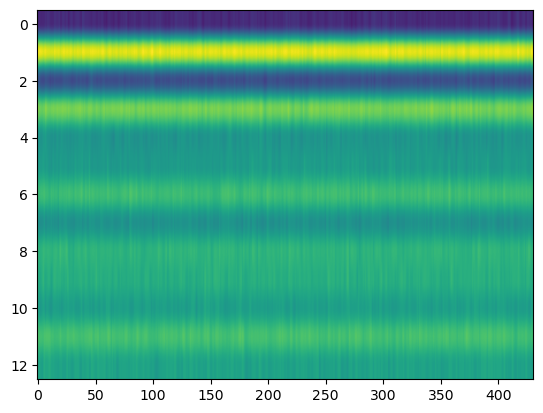

In [34]:
plt.imshow(S_MFCCs[0], aspect='auto')
plt.show()

In [35]:
S_MFCCs = [y.T for y in S_MFCCs]
S_MFCCs_test = [y.T for y in S_MFCCs_test]

In [36]:
S_MFCCs_inverted = []
for s in S_MFCCs:
    S_MFCCs_inverted.append(1 - s)
S_MFCCs = S_MFCCs_inverted


S_MFCCs_inverted_test = []
for s in S_MFCCs_test:
    S_MFCCs_inverted_test.append(1 - s)
S_MFCCs_test = S_MFCCs_inverted_test

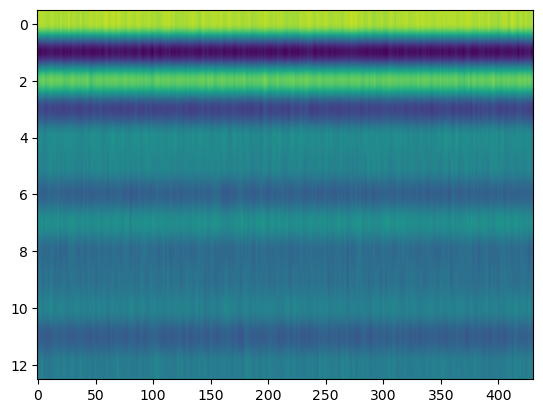

In [37]:
plt.imshow(S_MFCCs[0].T, aspect='auto')
plt.show()

In [10]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [39]:
S_scaled = [scale_minmax(i) for i in S_MFCCs]

S_scaled_test = [scale_minmax(i) for i in S_MFCCs_test]

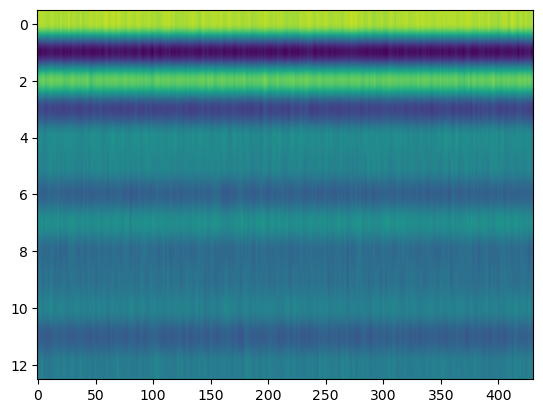

In [40]:
plt.imshow(S_scaled[0].T, aspect='auto')
plt.show()

In [41]:
S_scaled = [np.flip(i) for i in S_scaled]

S_scaled_test = [np.flip(i) for i in S_scaled_test]

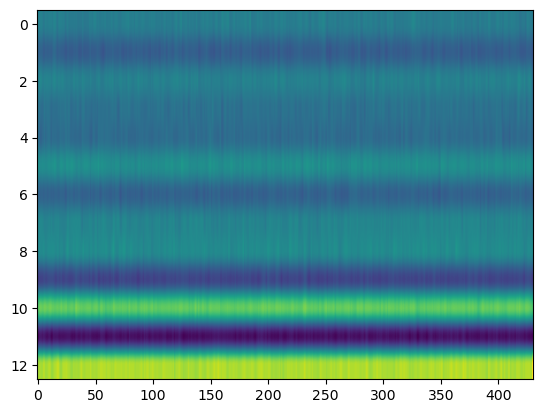

In [42]:
plt.imshow(S_scaled[0].T, aspect='auto')
plt.show()

In [43]:
x_train_acc = S_scaled.copy()
x_test_acc  = S_scaled_test.copy()

## Making Positive And Negative Data

In [44]:
class Utils:
    '''
       @returns a list of negative/incorrect lables for the given list of positive/correct labels
       y: torch.tensor
    '''    
    @staticmethod
    def get_y_negative(y, num_of_classes=2):
        y_neg = np.copy(y)
        
        for index, label in enumerate(y):
            one_of_n_rep = list(range(num_of_classes)) # [0, 9]
            one_of_n_rep.remove(label)
            y_neg[index] = one_of_n_rep[0]
        
        return y_neg
    
    '''
        * @params: x: image tensor (train/test size, 784)
                y: label (train/test size, 1)
        
        * @return: a new x with y tensor overlayed on it 
    '''
    @staticmethod
    def overlay_y_on_x(x, y, num_of_classes=2):
        x_clone = np.copy(x)
        scale = 5
        
        x_clone[:num_of_classes*scale, 0] *= x.max() 
        x_clone[scale*y : scale*y+scale, 0] = x.min() 
        return x_clone

In [45]:
x_pos = [Utils.overlay_y_on_x(x=i, y=j) for i, j in zip(S_scaled, y_train_en)]
y_neg = Utils.get_y_negative(y_train_en)
x_neg = [Utils.overlay_y_on_x(x=i, y=j) for i, j in zip(S_scaled, y_neg)]

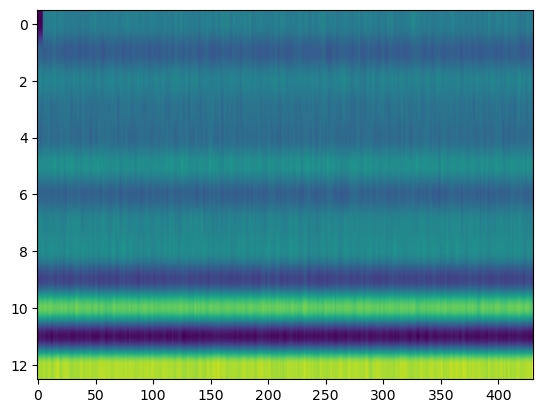

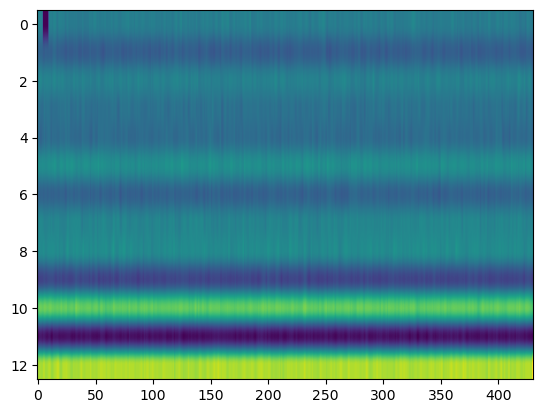

In [46]:
plt.imshow(x_pos[0].T, aspect='auto')
plt.show()

plt.imshow(x_neg[0].T, aspect='auto')
plt.show()

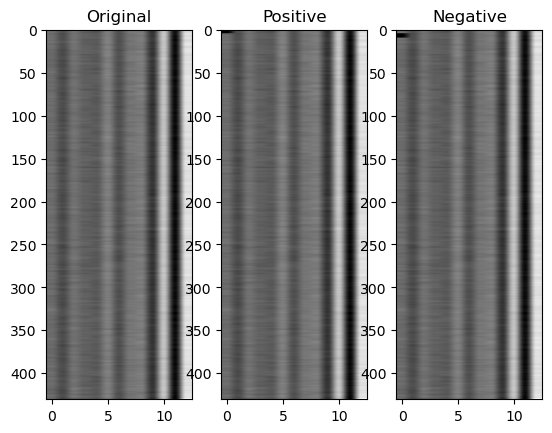

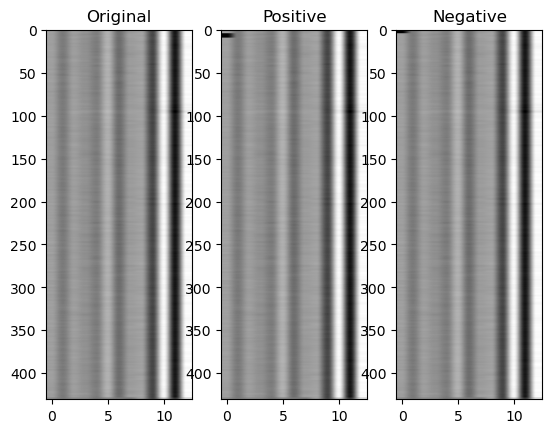

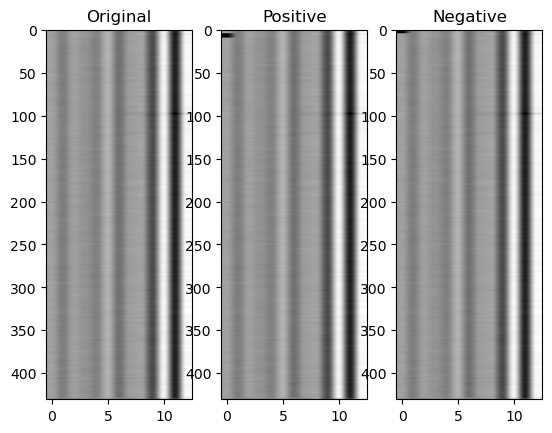

In [47]:
for i in range(3):
    fig, ax = plt.subplots(1, 3)
    
    ax[0].imshow(S_scaled[i], aspect='auto',cmap='gray')
    ax[0].set_title('Original')

    ax[1].imshow(x_pos[i], aspect='auto', cmap='gray')
    ax[1].set_title('Positive')

    ax[2].imshow(x_neg[i], aspect='auto', cmap='gray')
    ax[2].set_title('Negative')

    plt.show()

In [48]:
S_scaled = [i.flatten() for i in S_scaled]
x_pos    = [i.flatten() for i in x_pos]
x_neg    = [i.flatten() for i in x_neg]

## FF Architecture

In [49]:
class Layer(nn.Linear):
    def __init__(self, in_features, out_features, hyperparameters, bias=True, device='cpu', dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        
        self.relu      = torch.nn.ReLU()
        self.sigmoid   = torch.nn.Sigmoid()
        self.tanh      = torch.nn.Tanh()
        self.optimizer = torch.optim.Adam(self.parameters(), hyperparameters.lr)
        self.threshold = hyperparameters.threshold # goodness threshold
        self.epochs    = hyperparameters.epochs
        self.log_interval = hyperparameters.log_interval
        
        
    def forward(self, x):
        epsilon = 1e-4
        # layer normalization
        x_orientation = x / (x.norm(2, 1, keepdim=True) + epsilon) # epsilon is used to avoid division by 0

        return self.relu(
            torch.mm(x_orientation, self.weight.T) + 
            self.bias.unsqueeze(0)
        )
    
    def _calculate_goodness(self, activity_vector):
        return activity_vector.pow(2).mean(1).sqrt() # proposed goodness modifictaion
    
    def train(self, x_pos, x_neg):
        loss_values  = []
        g_pos_values = []
        g_neg_values = []

        # initialize figure
        fig = plt.figure(figsize=(12,8))

        for i in range(self.epochs):
            # Compute the goodness for the positive and negative samples
            '''
            goodness = sqrt( mean( sqr( activity_vector ) ) ).
            Eg: a_v = [1, 2, 3] -> sqr(a_v) = [1, 4, 9] -> mean(sqr(a_v)) = 14/3 = 4.666666666666667 -> sqrt(mean(sqr(a_v))) = 2.160246899469287
            '''
            g_pos = self._calculate_goodness(self.forward(x_pos))

            '''
            g_pos is 1D tensor of shape (train/test size,):
            g_pos = tensor([0.7, 0.9, ...................................., 0.8])

            '''
            g_neg = self._calculate_goodness(self.forward(x_neg))

            '''
            g_neg is 1D tensor of shape (train/test size,):
            g_neg = tensor([0.1, 0.2, ...................................., 0.1])

            '''

            # loss for the computed goodness
            '''
                * designed in such a way that 
                    - goodness of positive data increases with training,
                    - goodness of negative data decreases with training
            '''
            loss = torch.log(1 + torch.exp(
                torch.cat(
                    [-g_pos + self.threshold, g_neg - self.threshold]
                ))).mean()
            
            # proposed loss modification
            loss = torch.square(loss)
            '''
            torch.cat([-g_pos + self.threshold, g_neg - self.threshold]) 
            is 1D tensor of shape (2 * train/test size,)

            torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold])) 
            to ensure that all values are positive and to increase the difference between larger and smaller values
            is 1D tensor of shape (2 * train/test size,)

            '1 + ...' adds 1 to each of these exponential scores. This ensures that even if all the scores are zero, the loss will not be negative.
            result: 1D tensor of shape (2 * train/test size,)

            log(): apply natural log to the output
            result: 1D tensor of shape (2 * train/test size,)

            .mean() to take avg of all (2 * train/test size) values
            result: loss is scalar
            '''
            self.optimizer.zero_grad() # to avoid gradient accumulation/summation, set grads to zero before training

            loss.backward()            # Obtain the gradients. Do not confuse this with backpropagation. 
                                       # We are only calculating the grads for the current layer parameters (weights and biases). 
                                       # No chain rule is being applied.

            self.optimizer.step()      # update the gradients

            '''
            shape of weight: [num_of_nodes in out_features, num_of_nodes in in_features]
            shape of bias  : [num_of_nodes in out_features] (1D)
            '''

            if i % self.log_interval == 0:
                loss_values.append(loss.item())
                g_pos_values.append(g_pos.mean().item())
                g_neg_values.append(g_neg.mean().item())

                plt.subplot(3, 1, 1)
                plt.plot(loss_values, color='blue')
                plt.title('Loss During Training')

                plt.subplot(3, 1, 2)
                plt.plot(g_pos_values, color='green')
                plt.title('Goodness for Positive Images During Training')

                plt.subplot(3, 1, 3)
                plt.plot(g_neg_values, color='red')
                plt.title('Goodness for Negative Images During Training')

                plt.tight_layout()
                clear_output(wait=True)
                plt.show()

            print(f'Loss at step {i}: {loss.item()}')
        
        self.zero_grad(set_to_none=True)
              
        # return the output of the current layer after training
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [50]:
class Net(torch.nn.Module):
    def __init__(self, dims, hyperparameters):
        super().__init__()
        
        self.layers = []
        
        for dim in range(len(dims) - 1):
            self.layers += [Layer(dims[dim], dims[dim + 1], hyperparameters).to('cpu')]
        
        
    def predict(self, x, num_of_classes=2):
        goodness_per_label = []
        for label in range(num_of_classes):
            h = [Utils.overlay_y_on_x(i, label) for i in x]
            h = [i.flatten() for i in h]
            h = np.array(h)
            h = torch.Tensor(h)

            goodness = []
            for layer in self.layers:
                h = layer(h)

                goodness += [h.pow(2).mean(1).sqrt()]

            goodness = goodness[1:] # do not concat the first hidden layer
            goodness_per_label += [sum(goodness).unsqueeze(1)]

        goodness_per_label = torch.cat(goodness_per_label, dim=1)
        
        '''
        goodness_per_label.shape = [test_size, num_of_classes]
        return the indices of maximum values along dimension 1 (columns):
        1D tensor of shape (10000,):

        tensor([1, 9, ...................................., 1]) 
        '''

        return goodness_per_label.argmax(1)
    

    def train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos.clone(), x_neg.clone()
        
        for layer_number, layer in enumerate(self.layers):
            print(f'Training Layer: {layer_number}')
            h_pos, h_neg = layer.train(h_pos, h_neg)

In [51]:
S_scaled = np.array(S_scaled)
x_pos = np.array(x_pos)
x_neg = np.array(x_neg)

In [52]:
S_scaled = torch.tensor(S_scaled)
x_pos    = torch.tensor(x_pos)
x_neg    = torch.tensor(x_neg)

## Training

In [53]:
class Hyperparameters:
    epochs = 500
    lr = 0.1
    threshold = 2
    seed = 1234
    log_interval = 10

hyperparameters = Hyperparameters()

In [54]:
'''
for k-fold stratified cross validation 
this code needs to run k times with the given data
'''

net = Net([x_pos.shape[1], 500, 1000, 1000], hyperparameters)

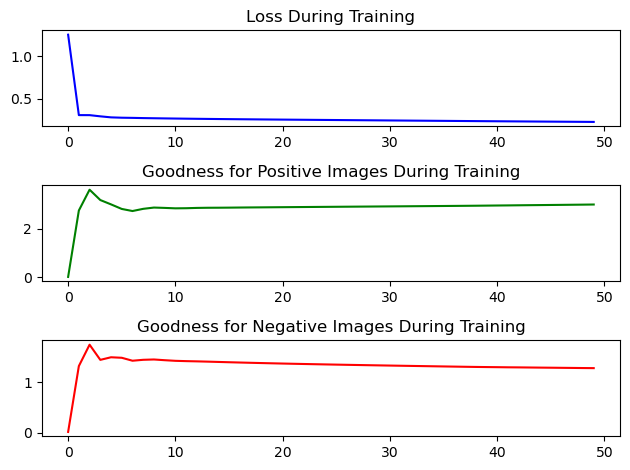

Loss at step 490: 0.22622323036193848
Loss at step 491: 0.22614318132400513
Loss at step 492: 0.2260642945766449
Loss at step 493: 0.22598563134670258
Loss at step 494: 0.22590729594230652
Loss at step 495: 0.2258293181657791
Loss at step 496: 0.22575122117996216
Loss at step 497: 0.22567391395568848
Loss at step 498: 0.22559645771980286
Loss at step 499: 0.22551965713500977


In [55]:
start_train_time = time.time() 
net.train(x_pos, x_neg)
end_train_time = time.time()

In [56]:
end_train_time - start_train_time

82.49538612365723

## Inference

In [57]:
train_acc = net.predict(x_train_acc)

In [58]:
test_acc = net.predict(x_test_acc)

In [59]:
y_train_en = torch.Tensor(y_train_en)
y_test_en = torch.Tensor(y_test_en)

In [60]:
train_acc.eq(y_train_en).float().mean().item() * 100

100.0

In [61]:
test_acc.eq(y_test_en).float().mean().item() * 100

95.99999785423279

In [62]:
train_cm = confusion_matrix(y_train_en, train_acc)
train_cm

array([[71,  0],
       [ 0, 27]])

In [63]:
test_cm = confusion_matrix(y_test_en, test_acc)
test_cm

array([[20,  1],
       [ 0,  4]])

## MFCCs with other ML Algorithms

In [11]:
class1_num_samples = len(class_1_preprocessed['Audio_samples'])
class2_num_samples = len(class_2_preprocessed['Audio_samples'])

In [12]:
class_1_df = pd.DataFrame(class_1_preprocessed['Audio_samples'],
                          index=list(range(class1_num_samples)))

In [ ]:
class_2_df = pd.DataFrame(class_2_preprocessed['Audio_samples'],
                          index=list(range(class1_num_samples, class1_num_samples + class2_num_samples)))

In [ ]:
frames = [class_1_df, class_2_df]

In [ ]:
df = pd.concat(frames)

In [ ]:
df.shape

In [ ]:
X = df.drop(['Label'], axis=1)
y = df['Label']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)

LabelEncoder()

In [ ]:
y_train_en = label_encoder.transform(y_train)
y_test_en = label_encoder.transform(y_test)

In [ ]:
S_MFCCs = [
    librosa.feature.mfcc(
        y=i, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        n_mfcc=n_mfcc) 
    for i in X_train.Audio_samples]

S_MFCCs_test = [
    librosa.feature.mfcc(
        y=i, 
        n_fft=n_fft, 
        hop_length=hop_length, 
        n_mfcc=n_mfcc) 
    for i in X_test.Audio_samples]

In [ ]:
S_MFCCs[0].shape

(13, 431)

In [ ]:
S_MFCCs = [y.T for y in S_MFCCs]
S_MFCCs_test = [y.T for y in S_MFCCs_test]

In [ ]:
S_MFCCs_inverted = []
for s in S_MFCCs:
    S_MFCCs_inverted.append(1 - s)
S_MFCCs = S_MFCCs_inverted


S_MFCCs_inverted_test = []
for s in S_MFCCs_test:
    S_MFCCs_inverted_test.append(1 - s)
S_MFCCs_test = S_MFCCs_inverted_test

In [ ]:
S_scaled = [scale_minmax(i) for i in S_MFCCs]

S_scaled_test = [scale_minmax(i) for i in S_MFCCs_test]

In [ ]:
S_scaled = [np.flip(i) for i in S_scaled]

S_scaled_test = [np.flip(i) for i in S_scaled_test]

In [64]:
X_train = S_scaled

In [66]:
X_test = [i.flatten() for i in S_scaled_test]
X_test = np.array(X_test)

### KNN

In [6]:
knn_clf = KNeighborsClassifier(n_neighbors=5)

In [7]:
start_train_time = time.time()
knn_clf.fit(X_train, y_train_en)
end_train_time = time.time()

In [8]:
end_train_time - start_train_time

In [9]:
knn_train_pred = knn_clf.predict(X_train)
knn_test_pred = knn_clf.predict(X_test)

In [10]:
accuracy_score(y_train_en, knn_train_pred)

In [11]:
accuracy_score(y_test_en, knn_test_pred)

In [12]:
precision_score(y_train_en, knn_train_pred), precision_score(y_test_en, knn_test_pred)

## SVC

In [13]:
svc_clf = SVC(gamma='auto')

In [14]:
start_train_time = time.time()
svc_clf.fit(X_train, y_train_en)
end_train_time = time.time()

In [15]:
end_train_time - start_train_time

In [16]:
svc_train_pred = svc_clf.predict(X_train)
svc_test_pred = svc_clf.predict(X_test)

In [17]:
accuracy_score(y_train_en, svc_train_pred)

In [18]:
accuracy_score(y_test_en, svc_test_pred)

In [19]:
precision_score(y_train_en, svc_train_pred), precision_score(y_test_en, svc_test_pred)

## Random Forest

In [20]:
rf_clf = RandomForestClassifier(max_depth=8, random_state=1234)

In [21]:
start_train_time = time.time()
rf_clf.fit(X_train, y_train_en)
end_train_time = time.time()

In [22]:
end_train_time - start_train_time

In [23]:
rf_train_pred = rf_clf.predict(X_train)
rf_test_pred = rf_clf.predict(X_test)

In [24]:
accuracy_score(y_train_en, rf_train_pred)

In [25]:
accuracy_score(y_test_en, rf_test_pred)

In [26]:
precision_score(y_train_en, rf_train_pred), precision_score(y_test_en, rf_test_pred)

## Backpropagation

In [27]:
X_train = torch.tensor(X_train)
y_train = torch.Tensor(y_train_en)

X_test = torch.tensor(X_test)
y_test = torch.Tensor(y_test_en)

In [28]:
# Fully connected neural network
class NeuralNetwork(nn.Module):
    def __init__(self, dims, num_classes):
        super(NeuralNetwork, self).__init__()
        self.layers = []
        for i in range(len(dims) - 1):
            self.layers += [nn.Linear(dims[i], dims[i+1])]
            
        self.output = nn.Linear(dims[-1], num_classes)
        self.layers = nn.ModuleList(self.layers)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x_clone = x.clone().detach()
        out = None
        for layer in self.layers:
            out = layer(x_clone)
            out = self.relu(out)
            x_clone = out

        if out is not None:
            out = self.output(out)
            out = self.sigmoid(out)
            
        return out

In [29]:
net_arc = [5603, 1000, 500, 500]
num_classes = 1
device = 'cpu'
learning_rate = 0.001
num_epochs = 200

model = NeuralNetwork(net_arc, num_classes).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

In [30]:
# Train the model

def train_BP():
    total_steps = 0
    for epoch in range(num_epochs): 
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train.unsqueeze(1)).mean()
        
        
        # Backprpagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_steps += 1
    
        if (epoch) % 10 == 0:
            print ('Epoch [{}/{}], Steps: {}, Loss: {}' 
                   .format(epoch+1, num_epochs, total_steps, loss.item()))
                
start_train_time = time.time()
train_BP()
end_train_time = time.time()

In [31]:
end_train_time - start_train_time

In [32]:
# Test the model
with torch.no_grad():
    outputs_train, outputs_test = model(X_train), model(X_test)
    predicted_train, predicted_test = outputs_train.data, outputs_test.data

In [33]:
y_train_pred = torch.Tensor([1.0 if i >= 0.5 else 0 for i in predicted_train])
y_test_pred = torch.Tensor([1.0 if i >= 0.5 else 0 for i in predicted_test])

In [34]:
y_train.eq(y_train_pred).float().mean().item() * 100

In [35]:
y_test.eq(y_test_pred).float().mean().item() * 100

In [36]:
precision_score(y_train, y_train_pred)

In [37]:
precision_score(y_train, y_train_pred), precision_score(y_test, y_test_pred)

## Different Classifiers' Performance
### 1. KNN
- **Constants**
    - k = 5
    - Without STE
    - normalization = librosa norm 2
- Test Acc : 0.8041958041958042
- Test Prec : 0.8085106382978723

### 2. SVM
- **Constants**
    - gamma = auto
    - Without STE
    - normalization = librosa norm 2
- Test Acc : 0.8041958041958042
- Test Prec : 0.8041958041958042

### 3. RF
- **Constants**
    - Without STE
    - normalization = librosa norm 2
- Test Acc : 0.9755244755244755
- Test Prec : 0.9744680851063829

### 4. BP
- **Constants**
    - Without STE
    - normalization = librosa norm 2
    - net_arc = [5603, 1000, 500, 500]
    - learning_rate = 0.001
    - num_epochs = 100
- Test Acc : 100.0
- Test Prec : 98.25174808502197
